In [320]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [41]:
district = 3

shot_data_raw = pd.read_csv('Shotspotter_data.csv')
shot_data_raw=shot_data_raw[shot_data_raw["DISTRICT"]==district]
for i in shot_data_raw.index:
    x=shot_data_raw.loc[i,"DATE"]
    x1=x.split(' ')
    x2=x1[0].split('/')
    shot_data_raw.loc[i,"time"]=x1[1]
    shot_data_raw.loc[i,'MONTH'] =int(x2[0])
    shot_data_raw.loc[i,"day"]=x2[1]
    shot_data_raw.loc[i,"YEAR"]=int(x2[2])
shot_data_raw=shot_data_raw.reset_index(drop=True)
shot_data_raw=shot_data_raw[["DATE","YEAR","MONTH","LATITUDE","LONGITUDE","LOCATION"]]

# if arrest = 0, it is not factored in.
# if arrest = 1, it is factored in.
hom_data_raw = pd.read_csv('Shooting_data.csv')
def clean(df, district, arrest):
    
    for i in df.index:
        x=df.loc[i,"Date"]
        x1=x.split(' ')
        x2=x1[0].split('/')
        df.loc[i,'MONTH'] =int(x2[0])
    df.columns
    df= df[df['District'] == int(district)]
    if arrest == 1:
        df= df[['Case Number', 'Date','Arrest','Year','MONTH','District','Latitude', 'Longitude','Location']]
        df['spotted'] = 0
        # df= df[df['Arrest'] == True]
        df.columns=["CASE ID", "DATE","ARREST","YEAR","MONTH","DISTRICT","LATITUDE","LONGITUDE","LOCATION","spotted"]
    else:
        df= df[['Date','Year','MONTH','District','Latitude', 'Longitude','Location']]
        df['spotted'] = 0
        df.columns=["DATE","YEAR","MONTH","DISTRICT","LATITUDE","LONGITUDE","LOCATION","spotted"]
    df= df.reset_index(drop=True)
    return df
hom_data_raw = clean(hom_data_raw, 3, 1)
hom_data_raw.head()


!!pip install geopy
from geopy import distance
import datetime
import re
pt1 = [hom_data_raw.loc[3,"LATITUDE"],hom_data_raw.loc[3,"LONGITUDE"]]
pt2 = [shot_data_raw.loc[1,"LATITUDE"],shot_data_raw.loc[1,"LONGITUDE"]]
print("Distance between events is ", distance.distance(pt1, pt2).km, ' km')
strdate1 = hom_data_raw.loc[3,"DATE"]
strdate2 = shot_data_raw.loc[1,"DATE"]
date1 = datetime.datetime.strptime(strdate1, "%m/%d/%Y %H:%M")
date2 = datetime.datetime.strptime(strdate2, "%m/%d/%Y %H:%M")
dt = date1-date2
print(date1)
print(date2)
print("Time between events is ", int(dt.total_seconds()/60))
def linked(df, P, T, delta, tau):
    for k in range(P.shape[0]):
        for q in range(P.shape[1]):
            if P[k][q] < delta and T[k][q] < tau and T[k][q] >= 0:
                df.loc[k, 'spotted'] += 1
def LD(hom_data,shot_data,year,month,delta,tau):
    #install libraries
    from geopy import distance
    import datetime
    #get the threshold values
    delta = delta
    tau = tau
    hom_data = hom_data[hom_data["YEAR"]==year]
    shot_data = shot_data[shot_data["YEAR"]==year]
    hom_data = hom_data[hom_data["MONTH"]==month]
    shot_data = shot_data[shot_data["MONTH"]==month]
    shot_data = shot_data.reset_index(drop = True)
    hom_data = hom_data.reset_index(drop=True)
    #define the function to determine linkage of shotspotter and shooting incidents based on the threshold values
    #Create the P and T matrices
    P = np.zeros((hom_data.shape[0], shot_data.shape[0]))
    T = np.zeros((hom_data.shape[0], shot_data.shape[0]))
    for i in hom_data.index:
        for j in shot_data.index:
            location1 = hom_data.loc[i,"LOCATION"]
            location2 = shot_data.loc[j,"LOCATION"]
            a1 = location1.split(' ')
            a2 = location2.split(' ')
            #pt1 = [float(re.sub('[^0-9.-]','', a1[2])),float(re.sub('[^0-9.-]','', a1[1]))]
            #pt2 = [float(re.sub('[^0-9.-]','', a2[2])),float(re.sub('[^0-9.-]','', a2[1]))]
            pt1 = [hom_data.loc[i,"LATITUDE"],hom_data.loc[i,"LONGITUDE"]]
            pt2 = [shot_data.loc[j,"LATITUDE"],shot_data.loc[j,"LONGITUDE"]]
            P[i][j] = distance.distance(pt1, pt2).km
            strdate1 = hom_data.loc[i,"DATE"]
            strdate2 = shot_data.loc[j,"DATE"]
            date1 = datetime.datetime.strptime(strdate1, "%m/%d/%Y %H:%M")
            date2 = datetime.datetime.strptime(strdate2, "%m/%d/%Y %H:%M")
            dt = date1-date2
            T[i][j] = int(dt.total_seconds() / 60)
    #Apply the function linked to the P and T matrices
    linked(hom_data, P,T,delta,tau)
    #return the linking distribution
    return hom_data

Distance between events is  3.2000326883527346  km
2018-02-02 00:04:00
2018-01-30 18:43:00
Time between events is  3201


In [42]:
## link events with spotted
delta=.3
tau=30
hom_data = pd.DataFrame()
for yr in np.arange(0, 4, 1):
    for mo in np.arange(0,12,1):
        hom_data = pd.concat([hom_data, LD(hom_data_raw,shot_data_raw,2018+yr,mo+1,delta,tau)])
hom_data.head(100)

,CASE ID,DATE,ARREST,YEAR,MONTH,DISTRICT,LATITUDE,LONGITUDE,LOCATION,spotted
0,JB101767,1/2/2018 14:55,True,2018,1.0,3,41.777465,-87.617264,"(41.777464689, -87.617264087)",0
1,JB106414,1/6/2018 11:12,True,2018,1.0,3,41.769885,-87.568652,"(41.769884528, -87.568652033)",0
2,JB106581,1/6/2018 13:00,True,2018,1.0,3,41.772273,-87.609385,"(41.772272507, -87.609385104)",0
0,JB138202,2/2/2018 0:04,False,2018,2.0,3,41.761450,-87.623211,"(41.761450225, -87.623211368)",0
1,JB150050,2/13/2018 0:57,False,2018,2.0,3,41.769326,-87.616119,"(41.769326209, -87.616119242)",1
...,...,...,...,...,...,...,...,...,...,...
8,JB450336,9/25/2018 13:35,False,2018,9.0,3,41.759634,-87.592040,"(41.759634198, -87.592040466)",0
9,JB450678,9/25/2018 17:30,False,2018,9.0,3,41.770296,-87.610540,"(41.770295656, -87.610540069)",1
10,JB457330,9/30/2018 18:36,False,2018,9.0,3,41.766958,-87.575098,"(41.766957927, -87.575097961)",0
0,JB464035,10/5/2018 18:46,False,2018,10.0,3,41.772944,-87.576479,"(41.772944101, -87.576479184)",1


In [43]:
hom_data["LINKED"] = 0
hom_data["CLEARED"] = 0
hom_data= hom_data.reset_index(drop=True)
for i in hom_data.index:
    if hom_data.loc[i, 'spotted'] > 0:
        hom_data.loc[i, 'LINKED'] = 1
    if hom_data.loc[i, 'ARREST'] == True:
        hom_data.loc[i, 'CLEARED'] = 1
hom_data = hom_data.drop(columns=['DATE', 'ARREST', 'LATITUDE', 'LONGITUDE', 'LOCATION'])
hom_data = hom_data.rename(columns = {'spotted':'SPOTTED'})

In [45]:
hom_data.head(100)

,CASE ID,YEAR,MONTH,DISTRICT,SPOTTED,LINKED,CLEARED
0,JB101767,2018,1.0,3,0,0,1
1,JB106414,2018,1.0,3,0,0,1
2,JB106581,2018,1.0,3,0,0,1
3,JB138202,2018,2.0,3,0,0,0
4,JB150050,2018,2.0,3,1,1,0
...,...,...,...,...,...,...,...
95,JB450336,2018,9.0,3,0,0,0
96,JB450678,2018,9.0,3,1,1,0
97,JB457330,2018,9.0,3,0,0,0
98,JB464035,2018,10.0,3,1,1,0


In [80]:
delta=.3
tau=30

def linkageRatio(delta, tau, homData):
    total = [0 for x in range(4)]
    linked = [0 for x in range(4)]
    ratio = [0 for x in range(4)]
    for yr in np.arange(0, 4, 1):
        df = homData[homData['YEAR'] == 2018 + yr]
        total[yr] = len(df)
        df = df[df['LINKED'] == 1]
        linked[yr] = len(df)
        ratio[yr] = linked[yr]/total[yr]
    return [ratio, linked, total]

[[0.504, 0.6179775280898876, 0.5609756097560976, 0.5056818181818182], [63, 55, 92, 89], [125, 89, 164, 176]]


In [125]:
totalLinkage = linkageRatio(delta, tau, hom_data)
hom_data_cleared = hom_data[hom_data['CLEARED'] == 1]
clearedLinkage = linkageRatio(delta, tau, hom_data_cleared)

[[0.504, 0.6179775280898876, 0.5609756097560976, 0.5056818181818182], [63, 55, 92, 89], [125, 89, 164, 176]]
[[0.5, 0.75, 0.3333333333333333, 0.75], [5, 3, 2, 3], [10, 4, 6, 4]]


In [107]:
totalLinkage[0][1]

0.6179775280898876

In [1]:
totalRatio = []
clearedTotalRatio = []
for i in np.arange(0, 4):
    totalRatio.append(totalLinkage[0][i])
    clearedTotalRatio.append(clearedLinkage[0][i])
print(totalRatio)
print(clearedTotalRatio)
a = np.atleast_1d(totalRatio)
b = np.atleast_1d(clearedTotalRatio)

print(stats.ttest_ind(a, b, equal_var = True, alternative='less'))

NameError: name 'np' is not defined

When we perform a hypothesis test on the linkage ratios with $H_0 = $ the mean linkage ratio of all shooting events, $\mu_0$, and $H_a < \mu_0$, we get a p-value of $0.37476$. Therefore, we do not have enough evidence to reject the hypothesis. Thus we can conclude that the difference in means could occur due to random change, and the linkage between shooting events and ShotSpotter data is not different for cleared shootings than all shootings.

Text(0.5, 1.0, 'Clearance of Shootings and their Linkage with Shotspotter Events in District 3')

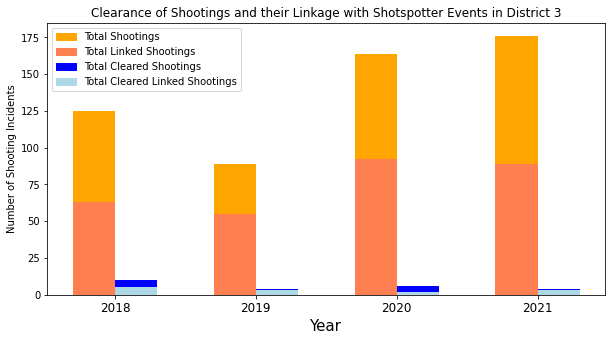

In [321]:
fig, ax = plt.subplots(figsize = [10, 5])
#matrix n x m = 4 x 3
x = np.arange(1)
for i in np.arange(4):
    plt.bar((x + i) - .15, totalLinkage[2][i], width = 0.3, color = 'orange')
    plt.bar((x + i) - .15, totalLinkage[1][i], width = 0.3, color = 'coral')
    plt.bar((x + i) + .15, clearedLinkage[2][i], width = 0.3, color = 'blue')
    sum = sum + clearedLinkage[2][i]
    plt.bar((x + i) + .15, clearedLinkage[1][i], width = 0.3, color = 'lightblue')
years = ['2018', '2019', '2020', '2021']
plt.xticks(np.arange(len(years)), years, size = 12)

ax.set_ylabel('Number of Shooting Incidents', color = 'k')
ax.set_xlabel("Year", color = 'k', size = 15)
orange_patch = mpatches.Patch(color='orange', label='Total Shootings')
coral_patch = mpatches.Patch(label='Total Linked Shootings', color='coral')
blue_patch = mpatches.Patch(color='blue', label='Total Cleared Shootings')
lightblue_patch = mpatches.Patch(color='lightblue', label='Total Cleared Linked Shootings')
plt.legend(handles=[orange_patch, coral_patch, blue_patch, lightblue_patch])

plt.title("Clearance of Shootings and their Linkage with Shotspotter Events in District 3")

Text(0.5, 1.0, 'Linkage of All Shootings vs Cleared Shootings with Shotspotter Events in District 3')

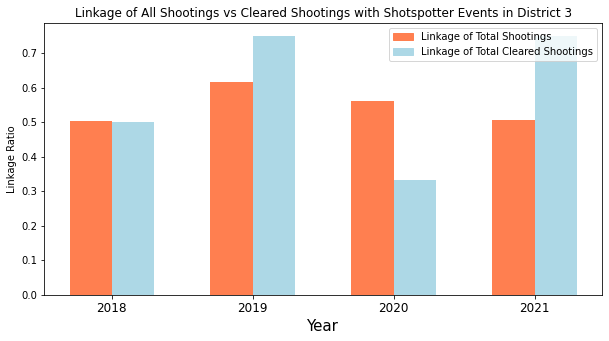

In [335]:
fig, ax = plt.subplots(figsize = [10, 5])
#matrix n x m = 4 x 3
x = np.arange(1)
for i in np.arange(4):
    plt.bar((x + i) - .15, totalLinkage[0][i], width = 0.3, color = 'coral')
    plt.bar((x + i) + .15, clearedLinkage[0][i], width = 0.3, color = 'lightblue')
years = ['2018', '2019', '2020', '2021']
plt.xticks(np.arange(len(years)), years, size = 12)
ax.set_ylabel('Linkage Ratio', color = 'k')
ax.set_xlabel("Year", color = 'k', size = 15)
coral_patch = mpatches.Patch(color='coral', label='Linkage of Total Shootings')
lightblue_patch = mpatches.Patch(color='lightblue', label='Linkage of Total Cleared Shootings')
plt.legend(handles=[coral_patch, lightblue_patch])
district = 3
plt.title("Linkage of All Shootings vs Cleared Shootings with Shotspotter Events in District " + str(district))

Use this function to do all analysis at once on a specific district. You may need to alter the data sets to make sure you have to data appropriate to the desired district. The ShotSpotter data includes multiple districts, but the shooting data is specific to district 3.

In [341]:
def clearanceLinkage(district, delta, tau, shotSpotData, shotData):

    shot_data_raw = pd.read_csv(shotSpotData)
    shot_data_raw=shot_data_raw[shot_data_raw["DISTRICT"]==district]
    for i in shot_data_raw.index:
        x=shot_data_raw.loc[i,"DATE"]
        x1=x.split(' ')
        x2=x1[0].split('/')
        shot_data_raw.loc[i,"time"]=x1[1]
        shot_data_raw.loc[i,'MONTH'] =int(x2[0])
        shot_data_raw.loc[i,"day"]=x2[1]
        shot_data_raw.loc[i,"YEAR"]=int(x2[2])
    shot_data_raw=shot_data_raw.reset_index(drop=True)
    shot_data_raw=shot_data_raw[["DATE","YEAR","MONTH","LATITUDE","LONGITUDE","LOCATION"]]

    # if arrest = 0, it is not factored in.
    # if arrest = 1, it is factored in.
    hom_data_raw = pd.read_csv(shotData)
    def clean(df, district):

        for i in df.index:
            x=df.loc[i,"Date"]
            x1=x.split(' ')
            x2=x1[0].split('/')
            df.loc[i,'MONTH'] =int(x2[0])
        df.columns
        df= df[df['District'] == int(district)]
        df= df[['Case Number', 'Date','Arrest','Year','MONTH','District','Latitude', 'Longitude','Location']]
        df['spotted'] = 0
        # df= df[df['Arrest'] == True]
        df.columns=["CASE ID", "DATE","ARREST","YEAR","MONTH","DISTRICT","LATITUDE","LONGITUDE","LOCATION","spotted"]
        df= df.reset_index(drop=True)
        return df
    hom_data_raw = clean(hom_data_raw, district)
    hom_data_raw.head()

    !!pip install geopy
    from geopy import distance
    import datetime
    import re
    pt1 = [hom_data_raw.loc[3,"LATITUDE"],hom_data_raw.loc[3,"LONGITUDE"]]
    pt2 = [shot_data_raw.loc[1,"LATITUDE"],shot_data_raw.loc[1,"LONGITUDE"]]
    print("Distance between events is ", distance.distance(pt1, pt2).km, ' km')
    strdate1 = hom_data_raw.loc[3,"DATE"]
    strdate2 = shot_data_raw.loc[1,"DATE"]
    date1 = datetime.datetime.strptime(strdate1, "%m/%d/%Y %H:%M")
    date2 = datetime.datetime.strptime(strdate2, "%m/%d/%Y %H:%M")
    dt = date1-date2
    print(date1)
    print(date2)
    print("Time between events is ", int(dt.total_seconds()/60))
    def linked(df, P, T, delta, tau):
        for k in range(P.shape[0]):
            for q in range(P.shape[1]):
                if P[k][q] < delta and T[k][q] < tau and T[k][q] >= 0:
                    df.loc[k, 'spotted'] += 1
    def LD(hom_data,shot_data,year,month,delta,tau):
        #install libraries
        from geopy import distance
        import datetime
        #get the threshold values
        delta = delta
        tau = tau
        hom_data = hom_data[hom_data["YEAR"]==year]
        shot_data = shot_data[shot_data["YEAR"]==year]
        hom_data = hom_data[hom_data["MONTH"]==month]
        shot_data = shot_data[shot_data["MONTH"]==month]
        shot_data = shot_data.reset_index(drop = True)
        hom_data = hom_data.reset_index(drop=True)
        #define the function to determine linkage of shotspotter and shooting incidents based on the threshold values
        #Create the P and T matrices
        P = np.zeros((hom_data.shape[0], shot_data.shape[0]))
        T = np.zeros((hom_data.shape[0], shot_data.shape[0]))
        for i in hom_data.index:
            for j in shot_data.index:
                location1 = hom_data.loc[i,"LOCATION"]
                location2 = shot_data.loc[j,"LOCATION"]
                a1 = location1.split(' ')
                a2 = location2.split(' ')
                #pt1 = [float(re.sub('[^0-9.-]','', a1[2])),float(re.sub('[^0-9.-]','', a1[1]))]
                #pt2 = [float(re.sub('[^0-9.-]','', a2[2])),float(re.sub('[^0-9.-]','', a2[1]))]
                pt1 = [hom_data.loc[i,"LATITUDE"],hom_data.loc[i,"LONGITUDE"]]
                pt2 = [shot_data.loc[j,"LATITUDE"],shot_data.loc[j,"LONGITUDE"]]
                P[i][j] = distance.distance(pt1, pt2).km
                strdate1 = hom_data.loc[i,"DATE"]
                strdate2 = shot_data.loc[j,"DATE"]
                date1 = datetime.datetime.strptime(strdate1, "%m/%d/%Y %H:%M")
                date2 = datetime.datetime.strptime(strdate2, "%m/%d/%Y %H:%M")
                dt = date1-date2
                T[i][j] = int(dt.total_seconds() / 60)
        #Apply the function linked to the P and T matrices
        linked(hom_data, P,T,delta,tau)
        #return the linking distribution
        return hom_data
    ## link events with spotted
    delta=delta
    tau=tau
    hom_data = pd.DataFrame()
    for yr in np.arange(0, 4, 1):
        for mo in np.arange(0,12,1):
            hom_data = pd.concat([hom_data, LD(hom_data_raw,shot_data_raw,2018+yr,mo+1,delta,tau)])
    hom_data["LINKED"] = 0
    hom_data["CLEARED"] = 0
    hom_data= hom_data.reset_index(drop=True)
    for i in hom_data.index:
        if hom_data.loc[i, 'spotted'] > 0:
            hom_data.loc[i, 'LINKED'] = 1
        if hom_data.loc[i, 'ARREST'] == True:
            hom_data.loc[i, 'CLEARED'] = 1
    hom_data = hom_data.drop(columns=['DATE', 'ARREST', 'LATITUDE', 'LONGITUDE', 'LOCATION'])
    hom_data = hom_data.rename(columns = {'spotted':'SPOTTED'})
    def linkageRatio(delta, tau, homData):
        total = [0 for x in range(4)]
        linked = [0 for x in range(4)]
        ratio = [0 for x in range(4)]
        for yr in np.arange(0, 4, 1):
            df = homData[homData['YEAR'] == 2018 + yr]
            total[yr] = len(df)
            df = df[df['LINKED'] == 1]
            linked[yr] = len(df)
            ratio[yr] = linked[yr]/total[yr]
        return [ratio, linked, total]
    totalLinkage = linkageRatio(delta, tau, hom_data)
    hom_data_cleared = hom_data[hom_data['CLEARED'] == 1]
    clearedLinkage = linkageRatio(delta, tau, hom_data_cleared)
    fig, ax = plt.subplots(figsize = [10, 5])
    #matrix n x m = 4 x 3
    x = np.arange(1)
    for i in np.arange(4):
        plt.bar((x + i) - .15, totalLinkage[2][i], width = 0.3, color = 'orange')
        plt.bar((x + i) - .15, totalLinkage[1][i], width = 0.3, color = 'coral')
        plt.bar((x + i) + .15, clearedLinkage[2][i], width = 0.3, color = 'blue')
        plt.bar((x + i) + .15, clearedLinkage[1][i], width = 0.3, color = 'lightblue')
    years = ['2018', '2019', '2020', '2021']
    plt.xticks(np.arange(len(years)), years, size = 12)

    ax.set_ylabel('Number of Shooting Incidents', color = 'k')
    ax.set_xlabel("Year", color = 'k', size = 15)
    orange_patch = mpatches.Patch(color='orange', label='Total Shootings')
    coral_patch = mpatches.Patch(label='Total Linked Shootings', color='coral')
    blue_patch = mpatches.Patch(color='blue', label='Total Cleared Shootings')
    lightblue_patch = mpatches.Patch(color='lightblue', label='Total Cleared Linked Shootings')
    plt.legend(handles=[orange_patch, coral_patch, blue_patch, lightblue_patch])
    plt.title("Clearance of Shootings and their Linkage with Shotspotter Events in District " + str(district))
    
    fig, ax = plt.subplots(figsize = [10, 5])
    #matrix n x m = 4 x 3
    x = np.arange(1)
    for i in np.arange(4):
        plt.bar((x + i) - .15, totalLinkage[0][i], width = 0.3, color = 'coral')
        plt.bar((x + i) + .15, clearedLinkage[0][i], width = 0.3, color = 'lightblue')
    years = ['2018', '2019', '2020', '2021']
    plt.xticks(np.arange(len(years)), years, size = 12)
    ax.set_ylabel('Linkage Ratio', color = 'k')
    ax.set_xlabel("Year", color = 'k', size = 15)
    coral_patch = mpatches.Patch(color='coral', label='Linkage of Total Shootings')
    lightblue_patch = mpatches.Patch(color='lightblue', label='Linkage of Total Cleared Shootings')
    plt.legend(handles=[coral_patch, lightblue_patch])
    plt.title("Linkage of All Shootings vs Cleared Shootings with Shotspotter Events in District " + str(district))

Distance between events is  3.2000326883527346  km
2018-02-02 00:04:00
2018-01-30 18:43:00
Time between events is  3201


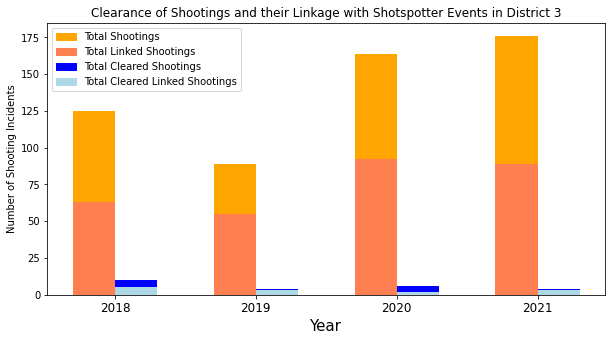

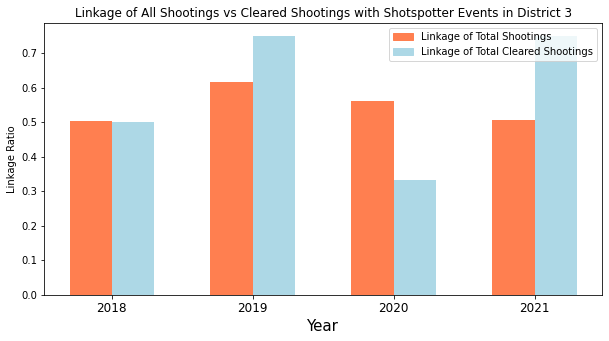

In [342]:
clearanceLinkage(3, .3, 30, 'Shotspotter_data.csv', 'Shooting_data.csv')